In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../..")

In [13]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change
from utilities_functions.explainer import generateExplanations
import torch
import pandas as pd
from torch.autograd import Variable
import tqdm

In [5]:
attributes =['title','manufacturer','price']

In [6]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/amazongoogle_hybrid.pth')

In [7]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,model,
                                                                        model.classifier,device=-1)

In [8]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                       'test_positives',128,model,
                                                                       model.classifier,device=-1)

In [9]:
testpos = []
for batch in testpos_classifier_inputs:
    testpos.append(Variable(batch.data.cuda(),requires_grad=True))

In [10]:
testneg = []
for batch in testneg_classifier_inputs:
    testneg.append(Variable(batch.data.cuda(),requires_grad=True))

In [11]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'negatives',128,model,
                                                                        model.classifier,device=-1)

In [12]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Amazon-Google/','positives',128,model,
                                                  model.classifier,device=-1)

In [14]:
negatives = []
for batch in neg_classifier_inputs:
    negatives.append(Variable(batch.data.cuda(),requires_grad=True))

In [15]:
positives = []
for batch in pos_classifier_inputs:
    positives.append(Variable(batch.data.cuda(),requires_grad=True))

In [16]:
model = model.cuda()

CuDNNError: 4: b'CUDNN_STATUS_INTERNAL_ERROR'

In [11]:
attribute_length = int((300*3)/len(attributes))
classifier_length = int(attribute_length*len(attributes))

## Test negatives analysis

In [12]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in negatives:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

Processing sample number 301
Processing sample number 302
Processing sample number 303
Processing sample number 304
Processing sample number 305
Processing sample number 306
Processing sample number 307
Processing sample number 308
Processing sample number 309
Processing sample number 310
Processing sample number 311
Processing sample number 312
Processing sample number 313
Processing sample number 314
Processing sample number 315
Processing sample number 316
Processing sample number 317
Processing sample number 318
Processing sample number 319
Processing sample number 320
Processing sample number 321
Processing sample number 322
Processing sample number 323
Processing sample number 324
Processing sample number 325
Processing sample number 326
Processing sample number 327
Processing sample number 328
Processing sample number 329
Processing sample number 330
Processing sample number 331
Processing sample number 332
Processing sample number 333
Processing sample number 334
Processing sam

Processing sample number 597
Processing sample number 598
Processing sample number 599
Processing sample number 600
Processing sample number 601
Processing sample number 602
Processing sample number 603
Processing sample number 604
Processing sample number 605
Processing sample number 606
Processing sample number 607
Processing sample number 608
Processing sample number 609
Processing sample number 610
Processing sample number 611
Processing sample number 612
Processing sample number 613
Processing sample number 614
Processing sample number 615
Processing sample number 616
Processing sample number 617
Processing sample number 618
Processing sample number 619
Processing sample number 620
Processing sample number 621
Processing sample number 622
Processing sample number 623
Processing sample number 624
Processing sample number 625
Processing sample number 626
Processing sample number 627
Processing sample number 628
Processing sample number 629
Processing sample number 630
Processing sam

Processing sample number 887
Processing sample number 888
Processing sample number 889
Processing sample number 890
Processing sample number 891
Processing sample number 892
Processing sample number 893
Processing sample number 894
Processing sample number 895
Processing sample number 896
Processing sample number 897
Processing sample number 898
Processing sample number 899
Processing sample number 900
Processing sample number 901
Processing sample number 902
Processing sample number 903
Processing sample number 904
Processing sample number 905
Processing sample number 906
Processing sample number 907
Processing sample number 908
Processing sample number 909
Processing sample number 910
Processing sample number 911
Processing sample number 912
Processing sample number 913
Processing sample number 914
Processing sample number 915
Processing sample number 916
Processing sample number 917
Processing sample number 918
Processing sample number 919
Processing sample number 920
Processing sam

Processing sample number 1173
Processing sample number 1174
Processing sample number 1175
Processing sample number 1176
Processing sample number 1177
Processing sample number 1178
Processing sample number 1179
Processing sample number 1180
Processing sample number 1181
Processing sample number 1182
Processing sample number 1183
Processing sample number 1184
Processing sample number 1185
Processing sample number 1186
Processing sample number 1187
Processing sample number 1188
Processing sample number 1189
Processing sample number 1190
Processing sample number 1191
Processing sample number 1192
Processing sample number 1193
Processing sample number 1194
Processing sample number 1195
Processing sample number 1196
Processing sample number 1197
Processing sample number 1198
Processing sample number 1199
Processing sample number 1200
Processing sample number 1201
Processing sample number 1202
Processing sample number 1203
Processing sample number 1204
Processing sample number 1205
Processing

Processing sample number 1455
Processing sample number 1456
Processing sample number 1457
Processing sample number 1458
Processing sample number 1459
Processing sample number 1460
Processing sample number 1461
Processing sample number 1462
Processing sample number 1463
Processing sample number 1464
Processing sample number 1465
Processing sample number 1466
Processing sample number 1467
Processing sample number 1468
Processing sample number 1469
Processing sample number 1470
Processing sample number 1471
Processing sample number 1472
Processing sample number 1473
Processing sample number 1474
Processing sample number 1475
Processing sample number 1476
Processing sample number 1477
Processing sample number 1478
Processing sample number 1479
Processing sample number 1480
Processing sample number 1481
Processing sample number 1482
Processing sample number 1483
Processing sample number 1484
Processing sample number 1485
Processing sample number 1486
Processing sample number 1487
Processing

Processing sample number 1735
Processing sample number 1736
Processing sample number 1737
Processing sample number 1738
Processing sample number 1739
Processing sample number 1740
Processing sample number 1741
Processing sample number 1742
Processing sample number 1743
Processing sample number 1744
Processing sample number 1745
Processing sample number 1746
Processing sample number 1747
Processing sample number 1748
Processing sample number 1749
Processing sample number 1750
Processing sample number 1751
Processing sample number 1752
Processing sample number 1753
Processing sample number 1754
Processing sample number 1755
Processing sample number 1756
Processing sample number 1757
Processing sample number 1758
Processing sample number 1759
Processing sample number 1760
Processing sample number 1761
Processing sample number 1762
Processing sample number 1763
Processing sample number 1764
Processing sample number 1765
Processing sample number 1766
Processing sample number 1767
Processing

Processing sample number 2023
Processing sample number 2024
Processing sample number 2025
Processing sample number 2026
Processing sample number 2027
Processing sample number 2028
Processing sample number 2029
Processing sample number 2030
Processing sample number 2031
Processing sample number 2032
Processing sample number 2033
Processing sample number 2034
Processing sample number 2035
Processing sample number 2036
Processing sample number 2037
Processing sample number 2038
Processing sample number 2039
Processing sample number 2040
Processing sample number 2041
Processing sample number 2042
Processing sample number 2043
Processing sample number 2044
Processing sample number 2045
Processing sample number 2046
Processing sample number 2047
Processing sample number 2048
Processing sample number 2049
Processing sample number 2050
Processing sample number 2051
Processing sample number 2052
Processing sample number 2053
Processing sample number 2054
Processing sample number 2055
Processing

Processing sample number 2299
Processing sample number 2300
Processing sample number 2301
Processing sample number 2302
Processing sample number 2303
Processing sample number 2304
Processing sample number 2305
Processing sample number 2306
Processing sample number 2307
Processing sample number 2308
Processing sample number 2309
Processing sample number 2310
Processing sample number 2311
Processing sample number 2312
Processing sample number 2313
Processing sample number 2314
Processing sample number 2315
Processing sample number 2316
Processing sample number 2317
Processing sample number 2318
Processing sample number 2319
Processing sample number 2320
Processing sample number 2321
Processing sample number 2322
Processing sample number 2323
Processing sample number 2324
Processing sample number 2325
Processing sample number 2326
Processing sample number 2327
Processing sample number 2328
Processing sample number 2329
Processing sample number 2330
Processing sample number 2331
Processing

Processing sample number 2580
Processing sample number 2581
Processing sample number 2582
Processing sample number 2583
Processing sample number 2584
Processing sample number 2585
Processing sample number 2586
Processing sample number 2587
Processing sample number 2588
Processing sample number 2589
Processing sample number 2590
Processing sample number 2591
Processing sample number 2592
Processing sample number 2593
Processing sample number 2594
Processing sample number 2595
Processing sample number 2596
Processing sample number 2597
Processing sample number 2598
Processing sample number 2599
Processing sample number 2600
Processing sample number 2601
Processing sample number 2602
Processing sample number 2603
Processing sample number 2604
Processing sample number 2605
Processing sample number 2606
Processing sample number 2607
Processing sample number 2608
Processing sample number 2609
Processing sample number 2610
Processing sample number 2611
Processing sample number 2612
Processing

Processing sample number 2856
Processing sample number 2857
Processing sample number 2858
Processing sample number 2859
Processing sample number 2860
Processing sample number 2861
Processing sample number 2862
Processing sample number 2863
Processing sample number 2864
Processing sample number 2865
Processing sample number 2866
Processing sample number 2867
Processing sample number 2868
Processing sample number 2869
Processing sample number 2870
Processing sample number 2871
Processing sample number 2872
Processing sample number 2873
Processing sample number 2874
Processing sample number 2875
Processing sample number 2876
Processing sample number 2877
Processing sample number 2878
Processing sample number 2879
Processing sample number 2880
Processing sample number 2881
Processing sample number 2882
Processing sample number 2883
Processing sample number 2884
Processing sample number 2885
Processing sample number 2886
Processing sample number 2887
Processing sample number 2888
Processing

Processing sample number 3145
Processing sample number 3146
Processing sample number 3147
Processing sample number 3148
Processing sample number 3149
Processing sample number 3150
Processing sample number 3151
Processing sample number 3152
Processing sample number 3153
Processing sample number 3154
Processing sample number 3155
Processing sample number 3156
Processing sample number 3157
Processing sample number 3158
Processing sample number 3159
Processing sample number 3160
Processing sample number 3161
Processing sample number 3162
Processing sample number 3163
Processing sample number 3164
Processing sample number 3165
Processing sample number 3166
Processing sample number 3167
Processing sample number 3168
Processing sample number 3169
Processing sample number 3170
Processing sample number 3171
Processing sample number 3172
Processing sample number 3173
Processing sample number 3174
Processing sample number 3175
Processing sample number 3176
Processing sample number 3177
Processing

Processing sample number 3428
Processing sample number 3429
Processing sample number 3430
Processing sample number 3431
Processing sample number 3432
Processing sample number 3433
Processing sample number 3434
Processing sample number 3435
Processing sample number 3436
Processing sample number 3437
Processing sample number 3438
Processing sample number 3439
Processing sample number 3440
Processing sample number 3441
Processing sample number 3442
Processing sample number 3443
Processing sample number 3444
Processing sample number 3445
Processing sample number 3446
Processing sample number 3447
Processing sample number 3448
Processing sample number 3449
Processing sample number 3450
Processing sample number 3451
Processing sample number 3452
Processing sample number 3453
Processing sample number 3454
Processing sample number 3455
Processing sample number 3456
Processing sample number 3457
Processing sample number 3458
Processing sample number 3459
Processing sample number 3460
Processing

Processing sample number 3703
Processing sample number 3704
Processing sample number 3705
Processing sample number 3706
Processing sample number 3707
Processing sample number 3708
Processing sample number 3709
Processing sample number 3710
Processing sample number 3711
Processing sample number 3712
Processing sample number 3713
Processing sample number 3714
Processing sample number 3715
Processing sample number 3716
Processing sample number 3717
Processing sample number 3718
Processing sample number 3719
Processing sample number 3720
Processing sample number 3721
Processing sample number 3722
Processing sample number 3723
Processing sample number 3724
Processing sample number 3725
Processing sample number 3726
Processing sample number 3727
Processing sample number 3728
Processing sample number 3729
Processing sample number 3730
Processing sample number 3731
Processing sample number 3732
Processing sample number 3733
Processing sample number 3734
Processing sample number 3735
Processing

Processing sample number 3986
Processing sample number 3987
Processing sample number 3988
Processing sample number 3989
Processing sample number 3990
Processing sample number 3991
Processing sample number 3992
Processing sample number 3993
Processing sample number 3994
Processing sample number 3995
Processing sample number 3996
Processing sample number 3997
Processing sample number 3998
Processing sample number 3999
Processing sample number 4000
Processing sample number 4001
Processing sample number 4002
Processing sample number 4003
Processing sample number 4004
Processing sample number 4005
Processing sample number 4006
Processing sample number 4007
Processing sample number 4008
Processing sample number 4009
Processing sample number 4010
Processing sample number 4011
Processing sample number 4012
Processing sample number 4013
Processing sample number 4014
Processing sample number 4015
Processing sample number 4016
Processing sample number 4017
Processing sample number 4018
Processing

Processing sample number 4267
Processing sample number 4268
Processing sample number 4269
Processing sample number 4270
Processing sample number 4271
Processing sample number 4272
Processing sample number 4273
Processing sample number 4274
Processing sample number 4275
Processing sample number 4276
Processing sample number 4277
Processing sample number 4278
Processing sample number 4279
Processing sample number 4280
Processing sample number 4281
Processing sample number 4282
Processing sample number 4283
Processing sample number 4284
Processing sample number 4285
Processing sample number 4286
Processing sample number 4287
Processing sample number 4288
Processing sample number 4289
Processing sample number 4290
Processing sample number 4291
Processing sample number 4292
Processing sample number 4293
Processing sample number 4294
Processing sample number 4295
Processing sample number 4296
Processing sample number 4297
Processing sample number 4298
Processing sample number 4299
Processing

Processing sample number 4554
Processing sample number 4555
Processing sample number 4556
Processing sample number 4557
Processing sample number 4558
Processing sample number 4559
Processing sample number 4560
Processing sample number 4561
Processing sample number 4562
Processing sample number 4563
Processing sample number 4564
Processing sample number 4565
Processing sample number 4566
Processing sample number 4567
Processing sample number 4568
Processing sample number 4569
Processing sample number 4570
Processing sample number 4571
Processing sample number 4572
Processing sample number 4573
Processing sample number 4574
Processing sample number 4575
Processing sample number 4576
Processing sample number 4577
Processing sample number 4578
Processing sample number 4579
Processing sample number 4580
Processing sample number 4581
Processing sample number 4582
Processing sample number 4583
Processing sample number 4584
Processing sample number 4585
Processing sample number 4586
Processing

Processing sample number 4832
Processing sample number 4833
Processing sample number 4834
Processing sample number 4835
Processing sample number 4836
Processing sample number 4837
Processing sample number 4838
Processing sample number 4839
Processing sample number 4840
Processing sample number 4841
Processing sample number 4842
Processing sample number 4843
Processing sample number 4844
Processing sample number 4845
Processing sample number 4846
Processing sample number 4847
Processing sample number 4848
Processing sample number 4849
Processing sample number 4850
Processing sample number 4851
Processing sample number 4852
Processing sample number 4853
Processing sample number 4854
Processing sample number 4855
Processing sample number 4856
Processing sample number 4857
Processing sample number 4858
Processing sample number 4859
Processing sample number 4860
Processing sample number 4861
Processing sample number 4862
Processing sample number 4863
Processing sample number 4864
Processing

Processing sample number 5120
Processing sample number 5121
Processing sample number 5122
Processing sample number 5123
Processing sample number 5124
Processing sample number 5125
Processing sample number 5126
Processing sample number 5127
Processing sample number 5128
Processing sample number 5129
Processing sample number 5130
Processing sample number 5131
Processing sample number 5132
Processing sample number 5133
Processing sample number 5134
Processing sample number 5135
Processing sample number 5136
Processing sample number 5137
Processing sample number 5138
Processing sample number 5139
Processing sample number 5140
Processing sample number 5141
Processing sample number 5142
Processing sample number 5143
Processing sample number 5144
Processing sample number 5145
Processing sample number 5146
Processing sample number 5147
Processing sample number 5148
Processing sample number 5149
Processing sample number 5150
Processing sample number 5151
Processing sample number 5152
Processing

Processing sample number 5403
Processing sample number 5404
Processing sample number 5405
Processing sample number 5406
Processing sample number 5407
Processing sample number 5408
Processing sample number 5409
Processing sample number 5410
Processing sample number 5411
Processing sample number 5412
Processing sample number 5413
Processing sample number 5414
Processing sample number 5415
Processing sample number 5416
Processing sample number 5417
Processing sample number 5418
Processing sample number 5419
Processing sample number 5420
Processing sample number 5421
Processing sample number 5422
Processing sample number 5423
Processing sample number 5424
Processing sample number 5425
Processing sample number 5426
Processing sample number 5427
Processing sample number 5428
Processing sample number 5429
Processing sample number 5430
Processing sample number 5431
Processing sample number 5432
Processing sample number 5433
Processing sample number 5434
Processing sample number 5435
Processing

Processing sample number 5678
Processing sample number 5679
Processing sample number 5680
Processing sample number 5681
Processing sample number 5682
Processing sample number 5683
Processing sample number 5684
Processing sample number 5685
Processing sample number 5686
Processing sample number 5687
Processing sample number 5688
Processing sample number 5689
Processing sample number 5690
Processing sample number 5691
Processing sample number 5692
Processing sample number 5693
Processing sample number 5694
Processing sample number 5695
Processing sample number 5696
Processing sample number 5697
Processing sample number 5698
Processing sample number 5699
Processing sample number 5700
Processing sample number 5701
Processing sample number 5702
Processing sample number 5703
Processing sample number 5704
Processing sample number 5705
Processing sample number 5706
Processing sample number 5707
Processing sample number 5708
Processing sample number 5709
Processing sample number 5710
Processing

Processing sample number 5966
Processing sample number 5967
Processing sample number 5968
Processing sample number 5969
Processing sample number 5970
Processing sample number 5971
Processing sample number 5972
Processing sample number 5973
Processing sample number 5974
Processing sample number 5975
Processing sample number 5976
Processing sample number 5977
Processing sample number 5978
Processing sample number 5979
Processing sample number 5980
Processing sample number 5981
Processing sample number 5982
Processing sample number 5983
Processing sample number 5984
Processing sample number 5985
Processing sample number 5986
Processing sample number 5987
Processing sample number 5988
Processing sample number 5989
Processing sample number 5990
Processing sample number 5991
Processing sample number 5992
Processing sample number 5993
Processing sample number 5994
Processing sample number 5995
Processing sample number 5996
Processing sample number 5997
Processing sample number 5998
Processing

Processing sample number 6244
Processing sample number 6245
Processing sample number 6246
Processing sample number 6247
Processing sample number 6248
Processing sample number 6249
Processing sample number 6250
Processing sample number 6251
Processing sample number 6252
Processing sample number 6253
Processing sample number 6254
Processing sample number 6255
Processing sample number 6256
Processing sample number 6257
Processing sample number 6258
Processing sample number 6259
Processing sample number 6260
Processing sample number 6261
Processing sample number 6262
Processing sample number 6263
Processing sample number 6264
Processing sample number 6265
Processing sample number 6266
Processing sample number 6267
Processing sample number 6268
Processing sample number 6269
Processing sample number 6270
Processing sample number 6271
Processing sample number 6272
Processing sample number 6273
Processing sample number 6274
Processing sample number 6275
Processing sample number 6276
Processing

Processing sample number 6535
Processing sample number 6536
Processing sample number 6537
Processing sample number 6538
Processing sample number 6539
Processing sample number 6540
Processing sample number 6541
Processing sample number 6542
Processing sample number 6543
Processing sample number 6544
Processing sample number 6545
Processing sample number 6546
Processing sample number 6547
Processing sample number 6548
Processing sample number 6549
Processing sample number 6550
Processing sample number 6551
Processing sample number 6552
Processing sample number 6553
Processing sample number 6554
Processing sample number 6555
Processing sample number 6556
Processing sample number 6557
Processing sample number 6558
Processing sample number 6559
Processing sample number 6560
Processing sample number 6561
Processing sample number 6562
Processing sample number 6563
Processing sample number 6564
Processing sample number 6565
Processing sample number 6566
Processing sample number 6567
Processing

Processing sample number 6820
Processing sample number 6821
Processing sample number 6822
Processing sample number 6823
Processing sample number 6824
Processing sample number 6825
Processing sample number 6826
Processing sample number 6827
Processing sample number 6828
Processing sample number 6829
Processing sample number 6830
Processing sample number 6831
Processing sample number 6832
Processing sample number 6833
Processing sample number 6834
Processing sample number 6835
Processing sample number 6836
Processing sample number 6837
Processing sample number 6838
Processing sample number 6839
Processing sample number 6840
Processing sample number 6841
Processing sample number 6842
Processing sample number 6843
Processing sample number 6844
Processing sample number 6845
Processing sample number 6846
Processing sample number 6847
Processing sample number 6848
Processing sample number 6849
Processing sample number 6850
Processing sample number 6851
Processing sample number 6852
Processing

Processing sample number 7100
Processing sample number 7101
Processing sample number 7102
Processing sample number 7103
Processing sample number 7104
Processing sample number 7105
Processing sample number 7106
Processing sample number 7107
Processing sample number 7108
Processing sample number 7109
Processing sample number 7110
Processing sample number 7111
Processing sample number 7112
Processing sample number 7113
Processing sample number 7114
Processing sample number 7115
Processing sample number 7116
Processing sample number 7117
Processing sample number 7118
Processing sample number 7119
Processing sample number 7120
Processing sample number 7121
Processing sample number 7122
Processing sample number 7123
Processing sample number 7124
Processing sample number 7125
Processing sample number 7126
Processing sample number 7127
Processing sample number 7128
Processing sample number 7129
Processing sample number 7130
Processing sample number 7131
Processing sample number 7132
Processing

Processing sample number 7392
Processing sample number 7393
Processing sample number 7394
Processing sample number 7395
Processing sample number 7396
Processing sample number 7397
Processing sample number 7398
Processing sample number 7399
Processing sample number 7400
Processing sample number 7401
Processing sample number 7402
Processing sample number 7403
Processing sample number 7404
Processing sample number 7405
Processing sample number 7406
Processing sample number 7407
Processing sample number 7408
Processing sample number 7409
Processing sample number 7410
Processing sample number 7411
Processing sample number 7412
Processing sample number 7413
Processing sample number 7414
Processing sample number 7415
Processing sample number 7416
Processing sample number 7417
Processing sample number 7418
Processing sample number 7419
Processing sample number 7420
Processing sample number 7421
Processing sample number 7422
Processing sample number 7423
Processing sample number 7424
Processing

Processing sample number 7666
Processing sample number 7667
Processing sample number 7668
Processing sample number 7669
Processing sample number 7670
Processing sample number 7671
Processing sample number 7672
Processing sample number 7673
Processing sample number 7674
Processing sample number 7675
Processing sample number 7676
Processing sample number 7677
Processing sample number 7678
Processing sample number 7679
Processing sample number 7680
Processing sample number 7681
Processing sample number 7682
Processing sample number 7683
Processing sample number 7684
Processing sample number 7685
Processing sample number 7686
Processing sample number 7687
Processing sample number 7688
Processing sample number 7689
Processing sample number 7690
Processing sample number 7691
Processing sample number 7692
Processing sample number 7693
Processing sample number 7694
Processing sample number 7695
Processing sample number 7696
Processing sample number 7697
Processing sample number 7698
Processing

Processing sample number 7946
Processing sample number 7947
Processing sample number 7948
Processing sample number 7949
Processing sample number 7950
Processing sample number 7951
Processing sample number 7952
Processing sample number 7953
Processing sample number 7954
Processing sample number 7955
Processing sample number 7956
Processing sample number 7957
Processing sample number 7958
Processing sample number 7959
Processing sample number 7960
Processing sample number 7961
Processing sample number 7962
Processing sample number 7963
Processing sample number 7964
Processing sample number 7965
Processing sample number 7966
Processing sample number 7967
Processing sample number 7968
Processing sample number 7969
Processing sample number 7970
Processing sample number 7971
Processing sample number 7972
Processing sample number 7973
Processing sample number 7974
Processing sample number 7975
Processing sample number 7976
Processing sample number 7977
Processing sample number 7978
Processing

Processing sample number 8228
Processing sample number 8229
Processing sample number 8230
Processing sample number 8231
Processing sample number 8232
Processing sample number 8233
Processing sample number 8234
Processing sample number 8235
Processing sample number 8236
Processing sample number 8237
Processing sample number 8238
Processing sample number 8239
Processing sample number 8240
Processing sample number 8241
Processing sample number 8242
Processing sample number 8243
Processing sample number 8244
Processing sample number 8245
Processing sample number 8246
Processing sample number 8247
Processing sample number 8248
Processing sample number 8249
Processing sample number 8250
Processing sample number 8251
Processing sample number 8252
Processing sample number 8253
Processing sample number 8254
Processing sample number 8255
Processing sample number 8256
Processing sample number 8257
Processing sample number 8258
Processing sample number 8259
Processing sample number 8260
Processing

Processing sample number 8504
Processing sample number 8505
Processing sample number 8506
Processing sample number 8507
Processing sample number 8508
Processing sample number 8509
Processing sample number 8510
Processing sample number 8511
Processing sample number 8512
Processing sample number 8513
Processing sample number 8514
Processing sample number 8515
Processing sample number 8516
Processing sample number 8517
Processing sample number 8518
Processing sample number 8519
Processing sample number 8520
Processing sample number 8521
Processing sample number 8522
Processing sample number 8523
Processing sample number 8524
Processing sample number 8525
Processing sample number 8526
Processing sample number 8527
Processing sample number 8528
Processing sample number 8529
Processing sample number 8530
Processing sample number 8531
Processing sample number 8532
Processing sample number 8533
Processing sample number 8534
Processing sample number 8535
Processing sample number 8536
Processing

Processing sample number 8781
Processing sample number 8782
Processing sample number 8783
Processing sample number 8784
Processing sample number 8785
Processing sample number 8786
Processing sample number 8787
Processing sample number 8788
Processing sample number 8789
Processing sample number 8790
Processing sample number 8791
Processing sample number 8792
Processing sample number 8793
Processing sample number 8794
Processing sample number 8795
Processing sample number 8796
Processing sample number 8797
Processing sample number 8798
Processing sample number 8799
Processing sample number 8800
Processing sample number 8801
Processing sample number 8802
Processing sample number 8803
Processing sample number 8804
Processing sample number 8805
Processing sample number 8806
Processing sample number 8807
Processing sample number 8808
Processing sample number 8809
Processing sample number 8810
Processing sample number 8811
Processing sample number 8812
Processing sample number 8813
Processing

Processing sample number 9062
Processing sample number 9063
Processing sample number 9064
Processing sample number 9065
Processing sample number 9066
Processing sample number 9067
Processing sample number 9068
Processing sample number 9069
Processing sample number 9070
Processing sample number 9071
Processing sample number 9072
Processing sample number 9073
Processing sample number 9074
Processing sample number 9075
Processing sample number 9076
Processing sample number 9077
Processing sample number 9078
Processing sample number 9079
Processing sample number 9080
Processing sample number 9081
Processing sample number 9082
Processing sample number 9083
Processing sample number 9084
Processing sample number 9085
Processing sample number 9086
Processing sample number 9087
Processing sample number 9088
Processing sample number 9089
Processing sample number 9090
Processing sample number 9091
Processing sample number 9092
Processing sample number 9093
Processing sample number 9094
Processing

Processing sample number 9343
Processing sample number 9344
Processing sample number 9345
Processing sample number 9346
Processing sample number 9347
Processing sample number 9348
Processing sample number 9349
Processing sample number 9350
Processing sample number 9351
Processing sample number 9352
Processing sample number 9353
Processing sample number 9354
Processing sample number 9355
Processing sample number 9356
Processing sample number 9357
Processing sample number 9358
Processing sample number 9359
Processing sample number 9360
Processing sample number 9361
Processing sample number 9362
Processing sample number 9363
Processing sample number 9364
Processing sample number 9365
Processing sample number 9366
Processing sample number 9367
Processing sample number 9368
Processing sample number 9369
Processing sample number 9370
Processing sample number 9371
Processing sample number 9372
Processing sample number 9373
Processing sample number 9374
Processing sample number 9375
Processing

Processing sample number 9623
Processing sample number 9624
Processing sample number 9625
Processing sample number 9626
Processing sample number 9627
Processing sample number 9628
Processing sample number 9629
Processing sample number 9630
Processing sample number 9631
Processing sample number 9632
Processing sample number 9633
Processing sample number 9634
Processing sample number 9635
Processing sample number 9636
Processing sample number 9637
Processing sample number 9638
Processing sample number 9639
Processing sample number 9640
Processing sample number 9641
Processing sample number 9642
Processing sample number 9643
Processing sample number 9644
Processing sample number 9645
Processing sample number 9646
Processing sample number 9647
Processing sample number 9648
Processing sample number 9649
Processing sample number 9650
Processing sample number 9651
Processing sample number 9652
Processing sample number 9653
Processing sample number 9654
Processing sample number 9655
Processing

Processing sample number 9902
Processing sample number 9903
Processing sample number 9904
Processing sample number 9905
Processing sample number 9906
Processing sample number 9907
Processing sample number 9908
Processing sample number 9909
Processing sample number 9910
Processing sample number 9911
Processing sample number 9912
Processing sample number 9913
Processing sample number 9914
Processing sample number 9915
Processing sample number 9916
Processing sample number 9917
Processing sample number 9918
Processing sample number 9919
Processing sample number 9920
Processing sample number 9921
Processing sample number 9922
Processing sample number 9923
Processing sample number 9924
Processing sample number 9925
Processing sample number 9926
Processing sample number 9927
Processing sample number 9928
Processing sample number 9929
Processing sample number 9930
Processing sample number 9931
Processing sample number 9932
Processing sample number 9933
Processing sample number 9934
Processing

Processing sample number 10173
Processing sample number 10174
Processing sample number 10175
Processing sample number 10176
Processing sample number 10177
Processing sample number 10178
Processing sample number 10179
Processing sample number 10180
Processing sample number 10181
Processing sample number 10182
Processing sample number 10183
Processing sample number 10184
Processing sample number 10185
Processing sample number 10186
Processing sample number 10187
Processing sample number 10188
Processing sample number 10189
Processing sample number 10190
Processing sample number 10191
Processing sample number 10192
Processing sample number 10193
Processing sample number 10194
Processing sample number 10195
Processing sample number 10196
Processing sample number 10197
Processing sample number 10198
Processing sample number 10199
Processing sample number 10200
Processing sample number 10201
Processing sample number 10202
Processing sample number 10203
Processing sample number 10204
Processi

In [13]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
negatives_variation_df.head(10)

,title,manufacturer,price
0,4.383166,4.357642,4.507064
1,4.879765,4.785270,5.075571
2,3.368449,3.796148,3.681652
3,4.196616,4.133256,4.382589
4,4.409397,4.466839,4.654592
5,3.787485,3.961265,3.973403
6,3.775152,3.919975,3.927136
7,4.966995,4.852158,5.109514
8,4.359575,4.508562,4.527522
9,3.792504,4.051654,3.948489


In [14]:
##save to file
negatives_variation_df.to_csv('experiment_results/neg_ri.csv',index=False)

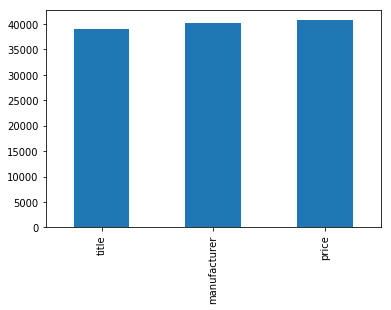

In [17]:
ri_sum_negatives = negatives_variation_df.sum(numeric_only=True)
ri_sum_negatives.plot.bar()

## Test positives analysis

In [16]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in positives:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

Processing sample number 294
Processing sample number 295
Processing sample number 296
Processing sample number 297
Processing sample number 298
Processing sample number 299
Processing sample number 300
Processing sample number 301
Processing sample number 302
Processing sample number 303
Processing sample number 304
Processing sample number 305
Processing sample number 306
Processing sample number 307
Processing sample number 308
Processing sample number 309
Processing sample number 310
Processing sample number 311
Processing sample number 312
Processing sample number 313
Processing sample number 314
Processing sample number 315
Processing sample number 316
Processing sample number 317
Processing sample number 318
Processing sample number 319
Processing sample number 320
Processing sample number 321
Processing sample number 322
Processing sample number 323
Processing sample number 324
Processing sample number 325
Processing sample number 326
Processing sample number 327
Processing sam

Processing sample number 587
Processing sample number 588
Processing sample number 589
Processing sample number 590
Processing sample number 591
Processing sample number 592
Processing sample number 593
Processing sample number 594
Processing sample number 595
Processing sample number 596
Processing sample number 597
Processing sample number 598
Processing sample number 599
Processing sample number 600
Processing sample number 601
Processing sample number 602
Processing sample number 603
Processing sample number 604
Processing sample number 605
Processing sample number 606
Processing sample number 607
Processing sample number 608
Processing sample number 609
Processing sample number 610
Processing sample number 611
Processing sample number 612
Processing sample number 613
Processing sample number 614
Processing sample number 615
Processing sample number 616
Processing sample number 617
Processing sample number 618
Processing sample number 619
Processing sample number 620
Processing sam

Processing sample number 882
Processing sample number 883
Processing sample number 884
Processing sample number 885
Processing sample number 886
Processing sample number 887
Processing sample number 888
Processing sample number 889
Processing sample number 890
Processing sample number 891
Processing sample number 892
Processing sample number 893
Processing sample number 894
Processing sample number 895
Processing sample number 896
Processing sample number 897
Processing sample number 898
Processing sample number 899
Processing sample number 900
Processing sample number 901
Processing sample number 902
Processing sample number 903
Processing sample number 904
Processing sample number 905
Processing sample number 906
Processing sample number 907
Processing sample number 908
Processing sample number 909
Processing sample number 910
Processing sample number 911
Processing sample number 912
Processing sample number 913
Processing sample number 914
Processing sample number 915
Processing sam

Processing sample number 1161
Processing sample number 1162
Processing sample number 1163
Processing sample number 1164
Processing sample number 1165
Processing sample number 1166


In [18]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.head(10)

,title,manufacturer,price
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,3.225466,4.254790,3.819329
5,2.408304,3.452988,2.606502
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,4.055089,5.053143,4.378626
9,0.947157,1.769830,1.308689


In [19]:
##Save results to file
positives_variation_df.to_csv('experiment_results/positives_ri.csv',index=False)

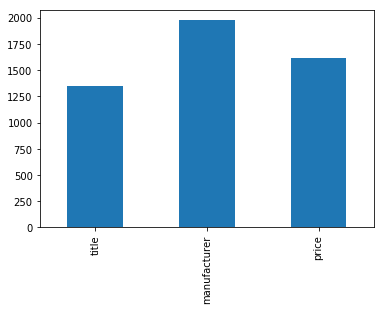

In [20]:
ri_sums = positives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

## Compute nearest neighbours

In [56]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [ ]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in negatives:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri[i][attributes.index(att)]
                                                                ,positives,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1

In [ ]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in positives:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri[i][attributes.index(att)]
                                                                ,negatives,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c:pos_ids[c])

In [ ]:
positives_closer_vectors_df['SampleID'] = pos_ids
negatives_closer_vectors_df['SampleID'] = neg_ids

In [ ]:
positives_closer_vectors_df.to_csv('experiment_results/positives_nn.csv',index=False)
negatives_closer_vectors_df.to_csv('experiment_results/negatives_nn.csv',index=False)